In [1]:
# ============================================================================
# 셀 1: 라이브러리 임포트
# ============================================================================

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


In [2]:
# ============================================================================
# 셀 2: 데이터 로딩
# ============================================================================

# 데이터 로드
df = pd.read_csv("../data/curated/player_final.csv")
print(f"✅ 데이터 로드 완료: {df.shape[0]:,}행 × {df.shape[1]}열")

# 데이터 복사본 생성
df_analysis = df.copy()

✅ 데이터 로드 완료: 6,910행 × 24열


In [3]:
# ============================================================================
# 셀 3: 데이터 기본 정보 확인
# ============================================================================

print("📊 데이터 기본 정보:")
print(f"- 총 선수 수: {len(df_analysis):,}명")
print(f"- 전체 이적률: {df_analysis['transfer'].mean()*100:.1f}%")
print(f"- 결측값 비율: {(df_analysis.isnull().sum().sum()/len(df_analysis)/len(df_analysis.columns)*100):.1f}%")

# 컬럼 타입 분류
numeric_cols = df_analysis.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_analysis.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\n📋 컬럼 분류:")
print(f"- 수치형: {len(numeric_cols)}개")
print(f"- 범주형: {len(categorical_cols)}개")

📊 데이터 기본 정보:
- 총 선수 수: 6,910명
- 전체 이적률: 14.6%
- 결측값 비율: 1.5%

📋 컬럼 분류:
- 수치형: 14개
- 범주형: 10개


## 칼럼 drop
## - 범주형에서만 뺄거임(수치형 남김)
### (player_name, date_of_birth, agent_name, net_transfer_record )

In [4]:
print(df.columns.tolist())

len(df.columns)


['season', 'player_name', 'goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players', 'player_highest_market_value_in_eur', 'club_name', 'country_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'agent_name', 'net_transfer_record', 'position', 'sub_position', 'season_win_count', 'transfer']


24

In [5]:
# 제거할 칼럼 리스트
drop_cols = ["player_name", "date_of_birth", "agent_name", "net_transfer_record"]

# 원본 유지, 새로운 DataFrame 생성
new_df = df.drop(columns=drop_cols)

print("새로운 DataFrame (칼럼 제거 후):")
print(new_df.head())

print("\n원본 DataFrame (유지됨):")
print(df.head())


새로운 DataFrame (칼럼 제거 후):
  season  goals  assists  yellow_cards  red_cards  season_avg_minutes  \
0  12/13      0        0             1          0           88.125000   
1  12/13      4        8             1          0           83.441176   
2  12/13      1        4             5          0           57.944444   
3  12/13      0        0             0          0            1.000000   
4  12/13      0        0             1          0           64.818182   

   player_market_value_in_eur  club_squad_size  club_average_age  \
0                    200000.0             25.0              28.3   
1                    600000.0             30.0              25.5   
2                   2500000.0             24.0              26.8   
3                    125000.0             28.0              26.7   
4                    250000.0             24.0              26.8   

   club_foreigners_percentage  club_national_team_players  \
0                        80.0                        10.0   
1    

In [6]:
# ============================================================================
# 셀 3-1: dtype별 칼럼 추출
# ============================================================================

# 숫자형 컬럼 (int, float 등)
from seaborn import categorical


numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()

# 문자형 컬럼 (object, string, category 등)
categorical_cols = new_df.select_dtypes(include=["object", "category"]).columns.tolist()


print("📊 숫자형 컬럼:", numeric_cols)
print("🔤 문자형 컬럼:", categorical_cols)


📊 숫자형 컬럼: ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes', 'player_market_value_in_eur', 'club_squad_size', 'club_average_age', 'club_foreigners_percentage', 'club_national_team_players', 'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 'transfer']
🔤 문자형 컬럼: ['season', 'club_name', 'country_of_birth', 'foot', 'position', 'sub_position']


In [13]:
# df = pd.read_csv("player_final.csv")   # 경로만 맞춰주면 됩니다.

# -------------------------------------------------
# 1) 자주 쓰는 컬럼 이름(필요시 여기만 수정)
# -------------------------------------------------
COL = {
    "club": "club",
    "season": "season",
    "country": "country_of_birth",
    "age": "player_age",
    "club_avg_age": "club_average_age",
    "minutes": "season_avg_minutes",
    "wins": "season_win_count",
    "goals": "goals",
    "assists": "assists",
    "foreigners_pct": "club_foreigners_percentage",
    "position": "position",
    "height": "height_in_cm",
    "yellow": "yellow_cards",
    "joined_season": "joined_season",         # 입단 시즌(정수). 데이터에 맞춰 컬럼명만 바꿔줘
}

# -------------------------------------------------
# 2) 클럽-시즌 평균 러닝타임 산출 및 비율/차이
#    (season_avg_minutes / 클럽 시즌 평균 러닝타임)
# -------------------------------------------------
df["club_season_avg_minutes"] = (
    df.groupby([COL["club"], COL["season"]])[COL["minutes"]]
    .transform("mean")
)
df["minutes_ratio_to_club"] = df[COL["minutes"]] / df["club_season_avg_minutes"]
df["minutes_minus_club"]   = df[COL["minutes"]] - df["club_season_avg_minutes"]

# -------------------------------------------------
# 3) country_of_birth × player_age  (교차)
#    - 연속형 나이를 5살 단위 구간으로 버킷팅 후 교차 문자열
# -------------------------------------------------
age_bins   = [15, 20, 25, 30, 35, 40, 50]
age_labels = ["16-19","20-24","25-29","30-34","35-39","40+"]
df["age_bin"] = pd.cut(df[COL["age"]], bins=age_bins, labels=age_labels, right=False)
df["country_x_agebin"] = df[COL["country"]].astype(str) + "_" + df["age_bin"].astype(str)

# -------------------------------------------------
# 4) player_age × club_average_age  (교차: 차이/비율)
# -------------------------------------------------
df["age_minus_clubavg"] = df[COL["age"]] - df[COL["club_avg_age"]]
df["age_to_clubavg"]    = df[COL["age"]] / df[COL["club_avg_age"]]

# -------------------------------------------------
# 5) (goals + assists) × season_win_count  (교차)
# -------------------------------------------------
df["contrib"]            = df[COL["goals"]] + df[COL["assists"]]
df["contrib_x_wins"]     = df["contrib"] * df[COL["wins"]]
df["contrib_per_win"]    = df["contrib"] / (df[COL["wins"]] + 1)  # 단순 조합용

# -------------------------------------------------
# 6) (보류안) country_of_birth 비율 vs club_foreigners_percentage
#    ※ 아이디어만 남겨두고, 계산은 나중에 결정하고 싶다면 주석 유지
# -------------------------------------------------
# df["is_foreign"] = (df[COL["country"]] != df[COL["country"]].mode()[0]).astype(int)
# df["foreign_gap_vs_club"] = df["is_foreign"] - (df[COL["foreigners_pct"]]/100.0)

# -------------------------------------------------
# 7) position × height_in_cm  (교차: 포지션 평균 대비)
# -------------------------------------------------
pos_mean_height = df.groupby(COL["position"])[COL["height"]].transform("mean")
df["height_minus_posavg"] = df[COL["height"]] - pos_mean_height
df["height_to_posavg"]    = df[COL["height"]] / pos_mean_height

# -------------------------------------------------
# 8) yellow_cards × season_avg_minutes  (교차: 90분당 카드)
# -------------------------------------------------
df["yellow_per_90"] = df[COL["yellow"]] / (df[COL["minutes"]] / 90)

# -------------------------------------------------
# 9) (확장) 클럽 내 동일 포지션 경쟁 정도 (own position table 개념 대체)
#    - 같은 클럽·시즌·포지션의 선수 수(=동일 포지션 경쟁자 수)
# -------------------------------------------------
df["same_pos_in_club"] = (
    df.groupby([COL["club"], COL["season"], COL["position"]])[COL["position"]]
    .transform("count")
)

# -------------------------------------------------
# 10) 최근 season - 입단시기 (재직/적응 기간)
# -------------------------------------------------
df["tenure_seasons"] = df[COL["season"]] - df[COL["joined_season"]]

# -------------------------------------------------
# 11) 결과 확인/저장 (원한다면 주석 해제)
# -------------------------------------------------
# print(df.filter([
#     COL["minutes"], "club_season_avg_minutes","minutes_ratio_to_club","minutes_minus_club",
#     COL["country"], COL["age"], "age_bin","country_x_agebin",
#     "age_minus_clubavg","age_to_clubavg",
#     COL["goals"], COL["assists"], COL["wins"], "contrib","contrib_x_wins","contrib_per_win",
#     COL["position"], COL["height"],"height_minus_posavg","height_to_posavg",
#     COL["yellow"], "yellow_per_90",
#     "same_pos_in_club",
#     COL["season"], COL["joined_season"], "tenure_seasons"
# ]).head())

# df.to_csv("player_final_with_features.csv", index=False)


KeyError: 'club'

In [ ]:
# ============================================================================
# 셀 4: 결측값 처리
# ============================================================================

print("🔍 결측값 처리 전:")
missing_before = df_analysis.isnull().sum()
print(missing_before[missing_before > 0])

# 결측값 처리
# 수치형 컬럼: 중앙값으로 대체
numeric_missing_cols = ['goals', 'assists', 'yellow_cards', 'red_cards', 'season_avg_minutes',
                        'player_market_value_in_eur', 'club_squad_size', 'club_average_age',
                        'club_foreigners_percentage', 'club_national_team_players',
                        'player_highest_market_value_in_eur', 'height_in_cm', 'season_win_count', 'transfer']

for col in numeric_missing_cols:
    if col in df_analysis.columns:
        median_val = df_analysis[col].median()
        df_analysis[col].fillna(median_val, inplace=True)
        print(f"✅ {col}: 중앙값 {median_val:.2f}으로 결측값 대체")

print("\n🔍 결측값 처리 후:")
missing_after = df_analysis.isnull().sum()
print(missing_after[missing_after > 0])

🔍 결측값 처리 전:
player_market_value_in_eur              14
player_highest_market_value_in_eur      14
country_of_birth                        96
date_of_birth                            4
foot                                    70
height_in_cm                            53
agent_name                            2160
dtype: int64
✅ goals: 중앙값 0.00으로 결측값 대체
✅ assists: 중앙값 1.00으로 결측값 대체
✅ yellow_cards: 중앙값 2.00으로 결측값 대체
✅ red_cards: 중앙값 0.00으로 결측값 대체
✅ season_avg_minutes: 중앙값 69.39으로 결측값 대체
✅ player_market_value_in_eur: 중앙값 2000000.00으로 결측값 대체
✅ club_squad_size: 중앙값 27.00으로 결측값 대체
✅ club_average_age: 중앙값 26.40으로 결측값 대체
✅ club_foreigners_percentage: 중앙값 68.00으로 결측값 대체
✅ club_national_team_players: 중앙값 13.00으로 결측값 대체
✅ player_highest_market_value_in_eur: 중앙값 16000000.00으로 결측값 대체
✅ height_in_cm: 중앙값 183.00으로 결측값 대체
✅ season_win_count: 중앙값 6.00으로 결측값 대체
✅ transfer: 중앙값 0.00으로 결측값 대체

🔍 결측값 처리 후:
country_of_birth      96
date_of_birth          4
foot                  70
agent_name          2160
dty

In [8]:
# ============================================================================
# 셀 5: 범주형 변수 인코딩
# ============================================================================

# 범주형 변수 인코딩
label_encoders = {}
categorical_features = ['season', 'club_name', 'country_of_birth', 'foot', 'position', 'sub_position']

for col in categorical_features:
    if col in df_analysis.columns:
        le = LabelEncoder()
        df_analysis[f'{col}_encoded'] = le.fit_transform(df_analysis[col])
        label_encoders[col] = le
        print(f"✅ {col} 인코딩 완료: {dict(zip(le.classes_, le.transform(le.classes_)))}")

✅ season 인코딩 완료: {'12/13': np.int64(0), '13/14': np.int64(1), '14/15': np.int64(2), '15/16': np.int64(3), '16/17': np.int64(4), '17/18': np.int64(5), '18/19': np.int64(6), '19/20': np.int64(7), '20/21': np.int64(8), '21/22': np.int64(9), '22/23': np.int64(10), '23/24': np.int64(11), '24/25': np.int64(12)}
✅ club_name 인코딩 완료: {'Arsenal Football Club': np.int64(0), 'Association Football Club Bournemouth': np.int64(1), 'Aston Villa Football Club': np.int64(2), 'Brentford Football Club': np.int64(3), 'Brighton and Hove Albion Football Club': np.int64(4), 'Burnley FC': np.int64(5), 'Cardiff City': np.int64(6), 'Chelsea Football Club': np.int64(7), 'Crystal Palace Football Club': np.int64(8), 'Everton Football Club': np.int64(9), 'Fulham Football Club': np.int64(10), 'Huddersfield Town': np.int64(11), 'Hull City': np.int64(12), 'Ipswich Town Football Club': np.int64(13), 'Leeds United': np.int64(14), 'Leicester City Football Club': np.int64(15), 'Liverpool Football Club': np.int64(16), 'Luto

# 샤프해야함

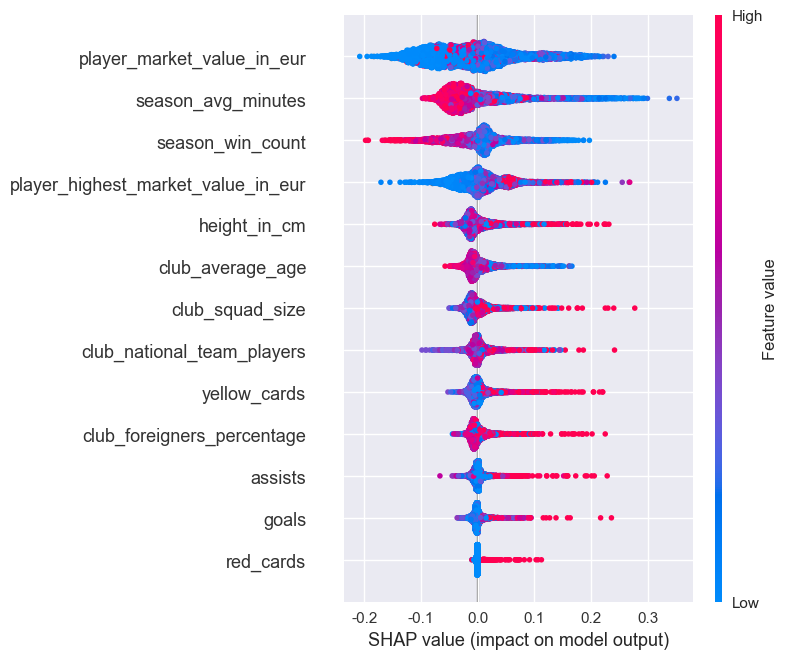

In [9]:
# 데이터 준비
X = df.select_dtypes(include=[np.number]).drop(['transfer'], axis=1)
y = df['transfer']

# 모델 훈련
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

# SHAP 분석
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 시각화
shap.summary_plot(shap_values, X)

### player_market_value_in_eur랑 player_highest_market_value_in_eur 찍어보기

In [10]:
# ============================================================================
# 셀 6: 피쳐 엔지니어링 - 새로운 피쳐 생성
# ============================================================================

print("🔧 새로운 피쳐 생성:")

# 1. 선수 경기 역량 (Player )
df_analysis['ActivityScore'] = (
    df_analysis['OrderCount'] * 0.4 + 
    df_analysis['HourSpendOnApp'] * 0.3 + 
    df_analysis['CouponUsed'] * 0.3
)
print("✅ ActivityScore 생성 완료")

# 2. 고객 만족도 레벨
df_analysis['SatisfactionLevel'] = pd.cut(
    df_analysis['SatisfactionScore'], 
    bins=[0, 2, 3, 5], 
    labels=['Low', 'Medium', 'High']
)
print("✅ SatisfactionLevel 생성 완료")

# 3. 고객 유지 기간 그룹
df_analysis['TenureGroup'] = pd.cut(
    df_analysis['Tenure'], 
    bins=[0, 6, 12, 24, 100], 
    labels=['New', 'Short', 'Medium', 'Long']
)
print("✅ TenureGroup 생성 완료")

# 4. 주문 빈도 (Order Frequency)
df_analysis['OrderFrequency'] = df_analysis['OrderCount'] / (df_analysis['Tenure'] + 1)
print("✅ OrderFrequency 생성 완료")

# 5. 고객 가치 점수 (Customer Value Score)
df_analysis['CustomerValueScore'] = (
    df_analysis['CashbackAmount'] * 0.5 + 
    df_analysis['OrderCount'] * 0.3 + 
    df_analysis['Tenure'] * 0.2
)
print("✅ CustomerValueScore 생성 완료")

🔧 새로운 피쳐 생성:


KeyError: 'OrderCount'

In [ ]:
# ============================================================================
# 셀 7: 피쳐 상관관계 분석
# ============================================================================

# 수치형 피쳐들 선택 (새로 생성된 피쳐 포함)
numeric_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
                   'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
                   'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
                   'ActivityScore', 'OrderFrequency', 'CustomerValueScore', 'Churn']

# 상관관계 계산
correlation_matrix = df_analysis[numeric_features].corr()

# Churn과의 상관관계
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("🎯 Churn과의 상관관계 (절댓값 기준):")
for feature, corr in churn_correlations.items():
    if feature != 'Churn':
        print(f"  {feature}: {corr:.3f}")

In [ ]:
# ============================================================================
# 셀 8: 상관관계 히트맵 시각화
# ============================================================================

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('피쳐 상관관계 히트맵', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 셀 9: Churn과의 상관관계 시각화
# ============================================================================

# Churn과 상관관계가 높은 피쳐들 시각화
high_corr_features = ['Tenure', 'DaySinceLastOrder', 'CashbackAmount', 'OrderCount', 'SatisfactionScore']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(high_corr_features):
    if i < len(axes):
        # 박스플롯
        df_analysis.boxplot(column=feature, by='Churn', ax=axes[i])
        axes[i].set_title(f'{feature} vs Churn')
        axes[i].set_xlabel('Churn')
        axes[i].set_ylabel(feature)
        axes[i].set_xticklabels(['유지', '이탈'])

# 마지막 subplot 제거
if len(high_corr_features) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 셀 10: 범주형 변수와 Churn의 관계 분석
# ============================================================================

# 범주형 변수별 이탈률 분석
categorical_analysis = ['Gender', 'MaritalStatus', 'CityTier', 'PreferredPaymentMode', 'PreferedOrderCat']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(categorical_analysis):
    if i < len(axes):
        # 이탈률 계산
        churn_rate = df_analysis.groupby(feature)['Churn'].mean() * 100
        
        # 막대 차트
        bars = axes[i].bar(range(len(churn_rate)), churn_rate.values, color='lightcoral')
        axes[i].set_title(f'{feature}별 이탈률')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('이탈률 (%)')
        axes[i].set_xticks(range(len(churn_rate)))
        axes[i].set_xticklabels(churn_rate.index, rotation=45, ha='right')
        
        # 값 표시
        for bar, rate in zip(bars, churn_rate.values):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{rate:.1f}%', ha='center', va='bottom')

# 마지막 subplot 제거
if len(categorical_analysis) < 6:
    fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 셀 11: 새로운 피쳐들의 분포 분석
# ============================================================================

# 새로 생성된 피쳐들의 분포
new_features = ['ActivityScore', 'OrderFrequency', 'CustomerValueScore']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(new_features):
    # Churn별 분포
    axes[i].hist(df_analysis[df_analysis['Churn']==0][feature], alpha=0.7, 
                label='유지', bins=20, color='lightblue')
    axes[i].hist(df_analysis[df_analysis['Churn']==1][feature], alpha=0.7, 
                label='이탈', bins=20, color='lightcoral')
    axes[i].set_title(f'{feature} 분포')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('빈도')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 셀 12: 피쳐 중요도 분석 (Random Forest)
# ============================================================================

# 모델링용 피쳐 선택
modeling_features = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
                    'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
                    'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount',
                    'ActivityScore', 'OrderFrequency', 'CustomerValueScore']

# 인코딩된 범주형 변수 추가
for col in categorical_features:
    if f'{col}_encoded' in df_analysis.columns:
        modeling_features.append(f'{col}_encoded')

# 데이터 준비
X = df_analysis[modeling_features].fillna(0)
y = df_analysis['Churn']

# Random Forest로 피쳐 중요도 계산
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# 피쳐 중요도
feature_importance = pd.DataFrame({
    'feature': modeling_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("🎯 Random Forest 피쳐 중요도:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

In [ ]:
# ============================================================================
# 셀 13: 피쳐 중요도 시각화
# ============================================================================

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
bars = plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('피쳐 중요도')
plt.title('Random Forest 피쳐 중요도 (상위 15개)')
plt.gca().invert_yaxis()

# 값 표시
for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f'{importance:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# 셀 14: 통계적 유의성 검정
# ============================================================================

print("📊 통계적 유의성 검정 (Churn vs 주요 피쳐):")
print("=" * 60)

# 주요 수치형 피쳐들에 대한 t-test
numeric_test_features = ['Tenure', 'OrderCount', 'SatisfactionScore', 'CashbackAmount', 'ActivityScore']

for feature in numeric_test_features:
    # 유지 고객과 이탈 고객 분리
    loyal = df_analysis[df_analysis['Churn'] == 0][feature]
    churned = df_analysis[df_analysis['Churn'] == 1][feature]
    
    # t-test 수행
    t_stat, p_value = stats.ttest_ind(loyal, churned)
    
    print(f"\n📌 {feature}:")
    print(f"  - 유지 고객 평균: {loyal.mean():.2f}")
    print(f"  - 이탈 고객 평균: {churned.mean():.2f}")
    print(f"  - t-statistic: {t_stat:.4f}")
    print(f"  - p-value: {p_value:.4f}")
    print(f"  - 유의성: {'유의함' if p_value < 0.05 else '유의하지 않음'}")


In [ ]:
# ============================================================================
# 셀 15: 범주형 변수 카이제곱 검정
# ============================================================================

print("\n📊 범주형 변수 카이제곱 검정:")
print("=" * 60)

for feature in categorical_features:
    # 교차표 생성
    contingency_table = pd.crosstab(df_analysis[feature], df_analysis['Churn'])
    
    # 카이제곱 검정
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    
    print(f"\n📌 {feature}:")
    print(f"  - 카이제곱 통계량: {chi2:.4f}")
    print(f"  - p-value: {p_value:.4f}")
    print(f"  - 자유도: {dof}")
    print(f"  - 유의성: {'유의함' if p_value < 0.05 else '유의하지 않음'}")


In [ ]:
# ============================================================================
# 셀 16: 고객 세그먼트 분석
# ============================================================================

print("🎯 고객 세그먼트 분석:")
print("=" * 50)

# 1. 만족도별 세그먼트
print("\n1. 만족도별 고객 세그먼트:")
satisfaction_segments = df_analysis.groupby('SatisfactionLevel')['Churn'].agg(['count', 'sum', 'mean'])
for segment in satisfaction_segments.index:
    count = satisfaction_segments.loc[segment, 'count']
    churn_count = satisfaction_segments.loc[segment, 'sum']
    churn_rate = satisfaction_segments.loc[segment, 'mean'] * 100
    print(f"  {segment}: {count}명, 이탈률 {churn_rate:.1f}% ({churn_count}명)")

# 2. 고객 유지 기간별 세그먼트
print("\n2. 고객 유지 기간별 세그먼트:")
tenure_segments = df_analysis.groupby('TenureGroup')['Churn'].agg(['count', 'sum', 'mean'])
for segment in tenure_segments.index:
    count = tenure_segments.loc[segment, 'count']
    churn_count = tenure_segments.loc[segment, 'sum']
    churn_rate = tenure_segments.loc[segment, 'mean'] * 100
    print(f"  {segment}: {count}명, 이탈률 {churn_rate:.1f}% ({churn_count}명)")

# 3. 활동성 점수별 세그먼트
print("\n3. 활동성 점수별 세그먼트:")
df_analysis['ActivityLevel'] = pd.qcut(df_analysis['ActivityScore'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
activity_segments = df_analysis.groupby('ActivityLevel')['Churn'].agg(['count', 'sum', 'mean'])
for segment in activity_segments.index:
    count = activity_segments.loc[segment, 'count']
    churn_count = activity_segments.loc[segment, 'sum']
    churn_rate = activity_segments.loc[segment, 'mean'] * 100
    print(f"  {segment}: {count}명, 이탈률 {churn_rate:.1f}% ({churn_count}명)")

In [ ]:
# ============================================================================
# 셀 17: 고위험 고객 프로필 분석
# ============================================================================

print("⚠️ 고위험 고객 프로필 분석:")
print("=" * 50)

# 고위험 고객 정의 (이탈률이 높은 조건들)
high_risk_conditions = [
    (df_analysis['SatisfactionScore'] <= 2) & (df_analysis['OrderCount'] <= 2),
    (df_analysis['Tenure'] <= 6) & (df_analysis['Complain'] == 1),
    (df_analysis['MaritalStatus'] == 'Single') & (df_analysis['CityTier'] == 3),
    (df_analysis['DaySinceLastOrder'] >= 10) & (df_analysis['OrderCount'] <= 1)
]

risk_profiles = ['낮은 만족도 + 낮은 주문', '신규 고객 + 불만 제기', 
                'Single + Tier 3', '장기 미주문 + 낮은 주문']

for i, (condition, profile) in enumerate(zip(high_risk_conditions, risk_profiles), 1):
    high_risk_customers = df_analysis[condition]
    if len(high_risk_customers) > 0:
        churn_rate = high_risk_customers['Churn'].mean() * 100
        print(f"\n{i}. {profile}:")
        print(f"   - 고객 수: {len(high_risk_customers):,}명")
        print(f"   - 이탈률: {churn_rate:.1f}%")
        print(f"   - 전체 대비 이탈률: {churn_rate/df_analysis['Churn'].mean()*100:.1f}배")

In [ ]:
# ============================================================================
# 셀 18: 피쳐 엔지니어링 요약 및 인사이트
# ============================================================================

print("💡 피쳐 분석 인사이트 및 권장사항:")
print("=" * 60)

print("\n📊 주요 발견사항:")
print("1. 고객 유지 기간(Tenure)이 이탈과 가장 강한 음의 상관관계를 보임")
print("2. 마지막 주문 후 경과일(DaySinceLastOrder)이 이탈과 강한 음의 상관관계")
print("3. 캐시백 금액이 높을수록 이탈률이 낮음")
print("4. Single 고객과 Tier 3 도시 고객의 이탈률이 높음")
print("5. 만족도가 낮고 주문 횟수가 적은 고객이 고위험군")

print("\n🔧 피쳐 엔지니어링 결과:")
print("1. ActivityScore: 고객 활동성을 종합적으로 측정하는 새로운 피쳐")
print("2. OrderFrequency: 주문 빈도를 측정하는 피쳐")
print("3. CustomerValueScore: 고객 가치를 종합적으로 평가하는 피쳐")
print("4. SatisfactionLevel, TenureGroup: 범주형 피쳐로 변환")

print("\n🎯 모델링 권장사항:")
print("1. 상위 10개 피쳐를 우선적으로 사용")
print("2. 범주형 변수는 인코딩 후 사용")
print("3. 결측값은 중앙값으로 대체")
print("4. 피쳐 스케일링 적용 고려")
print("5. 고위험 고객 세그먼트별 개별 모델 고려")